# Predicting Car Prices

In this project, we'll use a k-nearest neighbors algorithm to predict a car's market price using its attributes. The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

-----
Introduction to the Dataset
---------

In [43]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

the column names can be found in the description o fthe datset [here](https://archive.ics.uci.edu/ml/datasets/automobile)

In [44]:
col_names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 
             'aspiration', 'num-of-doors', 'body-style','drive-wheels',
             'engine-location', 'wheel-base', 'length', 'width', 'height',
             'curb-weight', 'engine-type','num-of-cylinders', 'engine-size',
             'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower',
             'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
# reading csv file and adding column names
cars = pd.read_csv('imports-85.data', names= col_names)

In [45]:
cars.sample(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
174,-1,65,toyota,diesel,turbo,four,sedan,fwd,front,102.4,...,110,idi,3.27,3.35,22.5,73,4500,30,33,10698
121,1,154,plymouth,gas,std,four,sedan,fwd,front,93.7,...,90,2bbl,2.97,3.23,9.4,68,5500,31,38,6692
187,2,94,volkswagen,diesel,turbo,four,sedan,fwd,front,97.3,...,97,idi,3.01,3.40,23.0,68,4500,37,42,9495
176,-1,65,toyota,gas,std,four,sedan,fwd,front,102.4,...,122,mpfi,3.31,3.54,8.7,92,4200,27,32,10898
60,0,115,mazda,gas,std,four,sedan,fwd,front,98.8,...,122,2bbl,3.39,3.39,8.6,84,4800,26,32,8495


In [46]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-rate     205 non-null float64
horsepower           205 non-nul

folowing columns are numeric and can be potentially used as features for the k-nearest neighbors algorithm:
- normalized-losses*
- wheel-base
- length
- width
- height
- curb-weight
- engine-size
- bore*
- stroke*
- compression-rate
- horsepower*
- peak-rpm*
- city-mpg
- highway-mpg

and the target parameter (column) is:
- price*


*these parameters need to be cleaned and/or converted to float

In [47]:
# subseting the columns with numerical values in a new dataframe
num_cols = ['normalized-losses', 'wheel-base', 'length', 'width',
            'height', 'curb-weight', 'engine-size', 'bore', 'stroke',
            'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg',
            'highway-mpg', 'price']
cars_num = cars[num_cols]

--------
Data Cleaning and normalizing
---------------

there are some columns,e.g., normalized-losses, that contain "?" which should be removed

In [48]:
# replacing "?" by np.nan
cars_num = cars_num.replace('?', np.nan).copy()

In [49]:
cars_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized-losses    164 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-size          205 non-null int64
bore                 201 non-null object
stroke               201 non-null object
compression-rate     205 non-null float64
horsepower           203 non-null object
peak-rpm             203 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                201 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


In [50]:
# converting object type columns to float
cars_num = cars_num.astype({'normalized-losses': float, 'bore':float, 
                            'stroke':float, 'horsepower':float, 
                            'peak-rpm':float, 'price':float})

In [51]:
# number of missing row values in each column
cars_num.isna().sum(axis=0)

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [52]:
# removing rows with missing price - since price is our target 
cars_num.dropna(axis=0, subset=['price'], inplace=True)

In [53]:
cars_num.isna().sum(axis=0)

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

since close to 15% of rows have missing values in "normalized-lossess" we drop the column entirely

In [54]:
cars_num.drop('normalized-losses', axis=1, inplace=True)

In [55]:
# other missing values in other columns are replaced by the mean of the column:
cars_num = cars_num.fillna(cars_num.mean())

In [56]:
# confirming that there are no missing values
cars_num.isna().sum(axis=0)

wheel-base          0
length              0
width               0
height              0
curb-weight         0
engine-size         0
bore                0
stroke              0
compression-rate    0
horsepower          0
peak-rpm            0
city-mpg            0
highway-mpg         0
price               0
dtype: int64

In [57]:
# Normalizing values (except for price)
price_col = cars_num['price']
cars_num = (cars_num - cars_num.mean()) / cars_num.std()
cars_num['price'] = price_col

In [58]:
# normalized dataset
cars_num.sample(5)

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
118,-0.840209,-1.371592,-0.994092,-1.211962,-1.232690,-0.887568,-1.345575,-0.085125,-0.190833,-0.947315,0.799836,1.840338,1.513310,5572.0
156,-0.510522,-0.641201,-0.708577,-0.313204,-0.917591,-0.695014,-0.524899,-0.717941,-0.290709,-0.893790,-0.664253,0.750542,0.926382,6938.0
153,-0.510522,-0.365276,-1.089263,2.178808,-0.532899,-0.839429,-1.047147,-0.717941,-0.290709,-1.107890,-0.664253,0.906227,0.926382,6918.0
107,1.500567,1.014351,1.194851,1.198344,0.897615,-0.165491,0.482294,-0.211688,-0.440523,-0.171200,-0.245942,-0.961995,-0.981133,11900.0
14,0.775256,1.201006,0.481066,0.789818,0.965274,0.893555,-0.077258,-0.211688,-0.290709,0.471102,-1.814608,-0.806310,-0.834401,24565.0


-------
Univariate Model
-----------

In [59]:
# k-nearest neighbor model with one feature
def knn_train_test(df,train_col, target_col, k):
    np.random.seed(1)
    len_df = len(df)
    # randomly shuffling the df
    df = df.iloc[np.random.permutation(len_df)]
    # 75% dataset for training and 25% for testing
    len_train = round(len_df * 0.75)
    train_df = df.iloc[:len_train]
    test_df = df.iloc[len_train:]
    # Kneighbor model using euclidean_distance, fitting on training datset and prediction on test datset
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', p=2)
    knn.fit(train_df[[train_col]], train_df[target_col])
    prediction = knn.predict(test_df[[train_col]])
    # root mean square error (RMSE) calcullation
    mse = mean_squared_error(test_df[target_col], prediction)
    rmse = mse ** 0.5
    return (rmse)
   

In [60]:
# using the function to find the best feature at different k values
k_value = [1, 3, 5, 7, 9]
features = cars_num.columns.drop('price')
rmse_list = []

for train_col in features: 
    rmse_k = []
    for k in k_value:
        rmse = knn_train_test(cars_num, train_col, 'price', k)
        rmse_k.append(rmse)
    rmse_list.append(rmse_k)

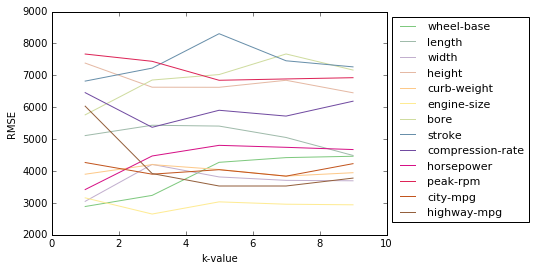

In [61]:
# plotting the RMSE vs k-value for all features
%matplotlib inline
cmap = plt.get_cmap('Accent')
for i in range(len(features)):
    color = cmap(float(i)/len(features))
    plt.plot(k_value,  rmse_list[i], label=features[i], c=color)
    plt.xlabel('k-value')
    plt.ylabel('RMSE')
    plt.xlim(0,10)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, 
               prop={'size': 11})


In [62]:
# calcaulating average RMSE values for each feature (parameter) across different k-values
rmse_param = {}
for i,par in enumerate(features):
    rmse_param[par] = round(sum(rmse_list[i]) / len(k_value))
    
# sorting the dictionary
sorted_rmse_param = sorted(rmse_param.items(), key=lambda x:x[1])
sorted_rmse_param

[('engine-size', 2949.0),
 ('width', 3695.0),
 ('wheel-base', 3856.0),
 ('curb-weight', 3988.0),
 ('city-mpg', 4056.0),
 ('highway-mpg', 4159.0),
 ('horsepower', 4423.0),
 ('length', 5099.0),
 ('compression-rate', 5930.0),
 ('height', 6788.0),
 ('bore', 6896.0),
 ('peak-rpm', 7154.0),
 ('stroke', 7416.0)]

Based on the results, it seems that the following parameters are the best to be used for the multivariate k-nearest neighbors model:
- engine-size
- width
- wheel-base
- curb_weight
- city-mpg (mile per gallon)
- highway-mpg (mile per gallon)
- horsepower

------
Multivariate Model
------

In [63]:
# k-nearest neighbor model with multi features (multivariate)
def knn_train_test_multi(df,train_cols, target_col, k):
    np.random.seed(1)
    len_df = len(df)
    # randomly shuffling the df
    df = df.iloc[np.random.permutation(len_df)]
    # 75% dataset for training and 25% for testing
    len_train = round(len_df * 0.75)
    train_df = df.iloc[:len_train]
    test_df = df.iloc[len_train:]
    # Kneighbor model using euclidean_distance, fitting on training datset and prediction on test datset
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', p=2)
    knn.fit(train_df[train_cols], train_df[target_col])
    prediction = knn.predict(test_df[train_cols])
    # root mean square error calcullation
    mse = mean_squared_error(test_df[target_col], prediction)
    rmse = mse ** 0.5
    return (rmse)

In [64]:
# running the fuction with the combination of 2 to 6 best features identified in the previous section
# and k-value=5
rmse_multi = {}
for i in range(2,7):
    #selecting first i parmaeters from sorted_rmse_param
    train_cols = [sorted_rmse_param[j][0] for j in range(i)]
    k = 5
    rmse_multi[i] = knn_train_test_multi(cars_num, train_cols, 'price', k)
# RMSE values with the combination of 2 to 6 best features
rmse_multi

{2: 2537.655173265273,
 3: 2568.5140030764874,
 4: 2434.3489411339533,
 5: 2535.4238149863622,
 6: 2554.233288797247}

The lowest RMSE value is when 4 features are considered, but the differences between RMSE values are not big. 

------------
Hyperparameter Tuning
-------------

To optimize the model, we vary the hyperparameter (k-value) value from 1 to 25

In [65]:
# running the fuction with 2 to 6 best combination of features with varying k-values
rmse_multi_hp = {}
for i in range(2,7):
    #selecting first i features from sorted_rmse_param
    train_cols = [sorted_rmse_param[j][0] for j in range(i)]
    rmse_mulit_k = []
    # k-value from 1 to 25
    kmax=25
    k_values = range(1, kmax+1)
    for k in k_values:
        rmse_mulit_k.append(knn_train_test_multi(cars_num, train_cols, 'price', k))
    rmse_multi_hp[i] = rmse_mulit_k


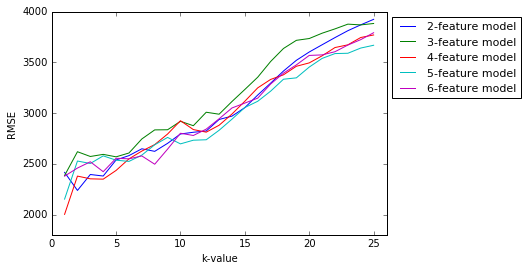

In [66]:
# plotting the RMSE vs k-value 
for i in rmse_multi_hp:
    plt.plot(k_values,  rmse_multi_hp[i], label='{}-feature model'.format(i))
    plt.xlabel('k-value')
    plt.ylabel('RMSE')
    plt.xlim(0,26)
    plt.ylim(1800,4000)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, 
               prop={'size': 11})


No big difference between 2- to 6-feature models. The lowest RMSE values are always for k < 5. 
The lowest RMSe if for 4-parameter model at k=1. The 4 features in the model are:
- engine-size
- width
- wheel-base
- curb_weight

---------------
k-fold Cross Validation
----------

To further improve the validation process of the models, instead of test/train validation, we can use the k-fold cross validation:

In [67]:
# k-nearest neighbor model with multi features and k-fold cross validation
def knn_train_test_multi_kfold(df,train_cols, target_col, k, kfold):
    # Kneighbor model
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', p=2)
    # instantiating the KFold class
    kf = KFold(kfold, shuffle=True, random_state=1)
    # implementing k-fold cross validation to calculate MSE usisng negative mean squared error:
    mse = cross_val_score(knn, df[train_cols], df[target_col],
                          scoring="neg_mean_squared_error", cv=kf)
    # calculating average of MSE values
    avg_mse = np.mean(mse)
    # root mean square error calcullation
    rmse = (-avg_mse) ** 0.5
    return (rmse)

In [68]:
# running the fuction with 2 to 6 best combination of features with varying k-values
# k-fold value = 5
rmse_multi_hp = {}
for i in range(2,7):
    #selecting first i features from sorted_rmse_param
    train_cols = [sorted_rmse_param[j][0] for j in range(i)]
    rmse_mulit_k = []
    # k-value from 1 to 25
    kmax=25
    k_values = range(1, kmax+1)
    # k-fold value
    kfold = 5
    for k in k_values:
        rmse_mulit_k.append(knn_train_test_multi_kfold(cars_num, train_cols,
                                                 'price', k, kfold))
    rmse_multi_hp[i] = rmse_mulit_k

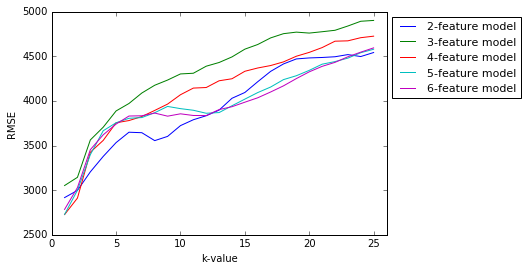

In [69]:
# plotting the RMSE vs k-value 
for i in rmse_multi_hp:
    plt.plot(k_values,  rmse_multi_hp[i], label='{}-feature model'.format(i))
    plt.xlabel('k-value')
    plt.ylabel('RMSE')
    plt.xlim(0,26)
    #plt.ylim(1800,4000)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, 
               prop={'size': 11})

The lowest values for RMSE is at k=1 for all the models:

In [70]:
for key, value in rmse_multi_hp.items():
    print('{0}-feature model: RMSE at k=1 is {1:.1f}'
          .format(key, value[0]))

2-feature model: RMSE at k=1 is 2916.8
3-feature model: RMSE at k=1 is 3051.7
4-feature model: RMSE at k=1 is 2726.5
5-feature model: RMSE at k=1 is 2728.2
6-feature model: RMSE at k=1 is 2784.5


The best model is the the 4-feature model at k=1 with the following parameters:
- engine-size
- width
- wheel-base
- curb_weight
